<a href="https://colab.research.google.com/github/jessiecai2002/SDS271-F23-Group7/blob/main/SDS271_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# TO SHOW INTERACTIVE PLOT
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.widgets import RangeSlider
import matplotlib.dates as dt
from ipywidgets import interactive

class IndustryAnalysis:
    def __init__(self, industry, events_file=None):
        self.price_data = pd.read_csv('Prices.csv')
        self.volume_data = pd.read_csv('Volume.csv')
        # Cleaning the dates columns
        self.price_data['Dates'] = pd.to_datetime(self.price_data['Dates'])
        self.volume_data['Dates'] = pd.to_datetime(self.volume_data['Dates'])
        # ValueErrors
        if industry not in self.price_data.columns:
            raise ValueError(f"Industry '{industry}' not found in data.")
        else:
            self.industry = industry
        # Use a list of economic and political events as an example

        if events_file:
            self.events = self.read_event_data(events_file)
        else:
            self.events = []
        self.length = 12
        self.width = 6
        self.fontsize = 10 # Also use for label size
        self.eventfontsize = 6

    def read_event_data(self, filename):
        events_df = pd.read_csv(filename)
        events_df['Start Date'] = pd.to_datetime(events_df['Start Date'])
        events_df['End Date'] = pd.to_datetime(events_df['End Date'])
        events_df = events_df.sort_values('Start Date')
        events = list(zip(events_df['Start Date'], events_df['End Date'], events_df['Event Name']))
        return events

    def calc_moving_average(self, window = 5):
        """
        Calculate period moving average for a given industry.
        :param industry: Name of the industry column.
        :param window: Number of periods to calculate moving average. Set the default window size to 5
        :return: DataFrame with moving averages.
        """
        self.window = window
        moving_average = self.volume_data.set_index('Dates')[self.industry].rolling(window = self.window).mean()
        return moving_average

    def calc_period_returns(self, period=1):
        """
        Calculate returns for prices of a given industry over a specified period.
        :param period: Number of periods to calculate percentage change for returns.
        :return: DataFrame with returns over the specified period.
        """
        period_returns = self.price_data.set_index('Dates')[self.industry].pct_change(periods=period)
        return period_returns

    def plot_all(self, plot_type='returns', window=5, period=1):
        """
        Plot all data, including events overlay.
        :param plot_type: Type of plot ('returns' or 'moving_average').
        :param window: Number of periods for calculating moving average.
        :param period: Number of periods for calculating returns.
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        if plot_type == 'returns':
            data = self.calc_period_returns(period)
            ax.plot(data.index, data, label=f'{self.industry} {period}-Periods Returns', color='blue')
        elif plot_type == 'moving_average':
            data = self.calc_moving_average(window)
            ax.plot(data.index, data, label=f'{self.industry} {window}-Periods Moving Average', color='green')
        else:
            raise ValueError("plot_type must be 'returns' or 'moving_average'.")

        # Formating
        #ax.set_title(f'{self.industry} {plot_type.replace("_", " ").title()} with Events')
        plt.figtext(0.5, 0.01, f'{self.industry} {plot_type.replace("_", " ").title()} with Events', ha='center', va='bottom',fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Value', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc='lower left')

        # Making space for the slider at the end
        fig.subplots_adjust(bottom=0.25)
        #ax.plot(data.index, data, label=f'Weekly Returns', color='blue')

        # Formating the slider
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Period", dt.date2num(data.index.min()), dt.date2num(data.index.max()))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            # The val passed to a callback by the RangeSlider will be a tuple of (min, max)

            # Update the image's colormap
            ax.set_xlim(xmin = slider.val[0], xmax = slider.val[1])

            # Redraw the figure to ensure it updates
            fig.canvas.draw()

        slider.on_changed(update)

        # Draw the events
        self.events_plot(ax)
        plt.show()

    def events_plot(self, ax):
        stagger = False  # Variable to alternate label positions
        for start, end, name in self.events:
            # Shading the event duration
            ax.axvspan(start, end, color='gray', alpha=0.3, ymax=1)

            # Determine label position
            label_y_position = ax.get_ylim()[1] * (0.9 if stagger else 0.95)
            stagger = not stagger  # Alternate for next label

            # Placing the label near the start of the event
            # if end < ax.xmin or start > ax.xmax:

            ax.text(start, label_y_position, name, horizontalalignment='left', verticalalignment='bottom', fontsize= self.eventfontsize, rotation=75)

    def series_plot(self, plot_type='returns'):
        """
        Plot periodic returns or moving average volume for a given industry.
        :param industry: Name of the industry.
        :param plot_type: Type of plot ('returns' or 'moving_average').
        """
        if plot_type not in ['returns', 'moving_average']:
            raise ValueError("plot_type must be 'returns' or 'moving_average'.")
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        if plot_type == 'returns':
            data = self.calc_period_returns()
            ax.plot(data.index, data, label=f'{self.industry} Periods Returns', color='blue')
        else:
            data = self.calc_moving_average()
            ax.plot(data.index, data, label=f'{self.industry} Moving Average', color='green')
        ax.set_title(f'{self.industry} {plot_type.replace("_", " ").title()}', fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Value', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc='lower left')


        # Making space for the slider at the end
        fig.subplots_adjust(bottom=0.25)

        # Formating the slider
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Period", dt.date2num(data.index.min()), dt.date2num(data.index.max()))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            # The val passed to a callback by the RangeSlider will be a tuple of (min, max)

            # Update the image's colormap
            ax.set_xlim(xmin = slider.val[0], xmax = slider.val[1])

            # Redraw the figure to ensure it updates
            fig.canvas.draw()

        # Call the function
        slider.on_changed(update)

        plt.show()


    def plot_prices_with_events(self):

        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.price_data
        ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Prices', color='blue')

        # Adding a title at the bottom
        plt.figtext(0.5, 0.01, f'{self.industry} Prices with Events', ha='center', va='bottom', fontsize= self.fontsize)

        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Price', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc=4)

        # Making space for the slider
        fig.subplots_adjust(bottom=0.25)

        # Formating the slider
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max()), valinit=(dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max())))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            start_date, end_date = dt.num2date(slider.val[0]), dt.num2date(slider.val[1])
            ax.set_xlim(start_date, end_date)
            fig.canvas.draw_idle()

        slider.on_changed(update)
        self.events_plot(ax)
        plt.show()


    def plot_volumes_with_events(self):
        """
        Plot the industry's trading volumes along with event shadings.
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.volume_data
        ax.plot(self.volume_data['Dates'], self.volume_data[self.industry], label=f'{self.industry} Volumes', color='green')

        # Adding a title at the bottom
        plt.figtext(0.5, 0.01, f'{self.industry} Volumes with Events', ha='center', va='bottom',fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Volume', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc=4)
        # Making space for the slider
        fig.subplots_adjust(bottom=0.25)

        # Formating the slider
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max()), valinit=(dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max())))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            start_date, end_date = dt.num2date(slider.val[0]), dt.num2date(slider.val[1])
            ax.set_xlim(start_date, end_date)
            fig.canvas.draw_idle()

        slider.on_changed(update)
        self.events_plot(ax)
        plt.show()

    def compare_prices(self, *other_industries):
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.price_data
        ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Prices')

        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            ax.plot(data['Dates'], data[industry], label=f'{industry} Prices')

        # Adding a title at the bottom
        plt.figtext(0.5, 0.01, 'Price Comparison with Events', ha='center', va='bottom', fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Price', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc="center left")

        # Making space for the slider
        fig.subplots_adjust(bottom=0.25)

        # Slider for adjusting the date range
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max()), valinit=(dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max())))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            start_date, end_date = dt.num2date(slider.val[0]), dt.num2date(slider.val[1])
            ax.set_xlim(start_date, end_date)
            fig.canvas.draw_idle()

        slider.on_changed(update)

        # Plotting events
        self.events_plot(ax)
        plt.show()

    def compare_volumes(self, *other_industries):
        """
        Compare the trading volumes of the current industry with other industries.
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.volume_data

        # Plotting volumes for the primary industry
        ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Volumes')

        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            ax.plot(data['Dates'], data[industry], label=f'{industry} Volumes')

        # Adding a title at the bottom
        plt.figtext(0.5, 0.01, 'Volume Comparison with Events', ha='center', va='bottom', fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Volume', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc=3)

        # Making space for the slider
        fig.subplots_adjust(bottom=0.25)

        # Slider for adjusting the date range
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max()), valinit=(dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max())))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            start_date, end_date = dt.num2date(slider.val[0]), dt.num2date(slider.val[1])
            ax.set_xlim(start_date, end_date)
            fig.canvas.draw_idle()

        slider.on_changed(update)

        # Plotting events
        self.events_plot(ax)

        plt.show()


    def compare_returns(self, period=1, *other_industries):
        """
        Compare the returns of the current industry with other industries over a specified period.
        :param period: Number of periods to calculate percentage change for returns.
        :param other_industries: Other industries to compare.
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.price_data

        # Plotting returns for the primary industry
        primary_returns = data.set_index('Dates')[self.industry].pct_change(periods=period)
        ax.plot(data['Dates'], primary_returns, label=f'{self.industry} {period}-Period Returns')

        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            industry_returns = data.set_index('Dates')[industry].pct_change(periods=period)
            ax.plot(data['Dates'], industry_returns, label=f'{industry} {period}-Periods Returns')

        # Adding a title at the bottom
        plt.figtext(0.5, 0.01, f'{period}-Periods Returns Comparison with Events', ha='center', va='bottom', fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Returns', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc=3)

        # Making space for the slider
        fig.subplots_adjust(bottom=0.25)

        # Slider for adjusting the date range
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max()), valinit=(dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max())))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            start_date, end_date = dt.num2date(slider.val[0]), dt.num2date(slider.val[1])
            ax.set_xlim(start_date, end_date)
            fig.canvas.draw_idle()

        slider.on_changed(update)
        # Plotting events
        self.events_plot(ax)
        plt.show()

    def compare_moving_averages(self,window=5, *other_industries):
        """
        Compare the moving averages of the current industry with other industries.
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.volume_data

        # Plotting moving averages for the primary industry
        ma_primary = data.set_index('Dates')[self.industry].rolling(window=window).mean()
        ax.plot(data['Dates'], ma_primary, label=f'{self.industry} Moving Average')

        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            ma_other = data.set_index('Dates')[industry].rolling(window=window).mean()
            ax.plot(data['Dates'], ma_other, label=f'{industry} Moving Average')

        # Adding a title at the bottom
        plt.figtext(0.5, 0.01, f'{window}-Periods Moving Average Comparison with Events', ha='center', va='bottom', fontsize= self.fontsize)
        ax.set_xlabel('Date', fontsize= self.fontsize)
        ax.set_ylabel('Moving Average', fontsize= self.fontsize)
        ax.tick_params(axis='both', labelsize= self.fontsize)
        ax.legend(loc=3)

        # Making space for the slider
        fig.subplots_adjust(bottom=0.25)

        # Slider for adjusting the date range
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max()), valinit=(dt.date2num(data['Dates'].min()), dt.date2num(data['Dates'].max())))
        slider.valtext.set_visible(False)

        # Update the graph with the new slider value
        def update(val):
            start_date, end_date = dt.num2date(slider.val[0]), dt.num2date(slider.val[1])
            ax.set_xlim(start_date, end_date)
            fig.canvas.draw_idle()

        slider.on_changed(update)

        # Plotting events
        self.events_plot(ax)

        plt.show()

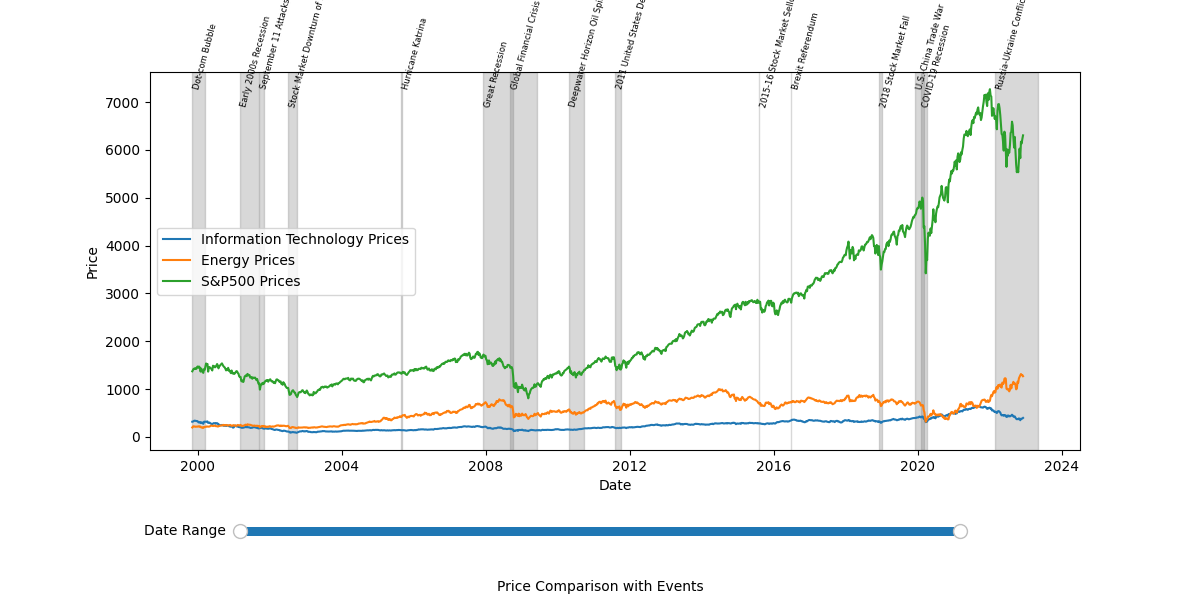

In [13]:
IT = IndustryAnalysis("Information Technology", events_file= 'events.csv')
# IT.series_plot('moving_average')

# IT.plot_all("moving_average",window=12)
# IT.plot_all("returns", period=8)
# IT.plot_prices_with_events()
# IT.plot_volumes_with_events()

IT.compare_prices('Energy','S&P500')
# IT.compare_volumes('S&P500')
# IT.compare_returns(8,'Industrials', 'S&P500')
# IT.compare_moving_averages(10,'Utilities')

# New Section